In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

sys.path.append("..")
from utils.util_functions import *

In [2]:
event_df = make_df("20180101", "20181231")

In [7]:
def make_score_df(team):
    res = []
    columns = ["相手", "得点", "安打", "失点", "被安打"]
    files = os.listdir(SCORE_DATA_DIR)
    for file in files:
        score_df = pd.read_csv(os.path.join(SCORE_DATA_DIR, file), encoding="cp932", index_col=0)
        if not name_dict[team] in score_df.index:
            continue
        opponent = score_df.index[0] if score_df.index[1] == name_dict[team] else score_df.index[1]
        team_score = score_df.loc[name_dict[team], "計"]
        team_hits = score_df.loc[name_dict[team], "安"]
        opponent_score = score_df.loc[opponent, "計"]
        opponent_hits = score_df.loc[opponent, "安"]
        res.append([opponent, team_score, team_hits, opponent_score, opponent_hits])
    df = pd.DataFrame(res, columns=columns)
    df["得点率"] = df["得点"] / df["安打"]
    df["失点率"] = df["失点"] / df["被安打"]
    return df

In [8]:
make_score_df("日本ハム").head()

,相手,得点,安打,失点,被安打,得点率,失点率
0,西,2,4,11,15,0.500000,0.733333
1,西,1,9,4,9,0.111111,0.444444
2,楽,2,6,0,6,0.333333,0.000000
3,楽,5,14,2,5,0.357143,0.400000
4,楽,3,6,1,4,0.500000,0.250000


In [10]:
column = "得点"

In [ ]:
diffs = []
stds = []
for team in pacific:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] #/ make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

In [ ]:
plt.scatter(diffs, stds)

In [ ]:
diffs = []
stds = []
for team in central:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] #/ make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

In [ ]:
plt.scatter(diffs, stds)

# 得点で見るか失点で見るか / 安打数を入れてもいいかも
# 標準偏差をそのまま使うか / 変動係数を使うか

In [17]:
diffs = []
stds = []
for team in pacific+central:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] / make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

西武 -0.12936799438793356 0.613558417522
ソフトバンク -0.11255035082854281 0.665868977826
日本ハム -0.11188805896839593 0.73001605495
オリックス -0.1256219925195241 0.738430371046
ロッテ -0.13409313985255622 0.73693614177
楽天 -0.11332040265998611 0.786334698231
広島 -0.13081643531445852 0.627011135613
ヤクルト -0.12723893097536543 0.663965375046
巨人 -0.11617775617173276 0.744661085481
ＤｅＮＡ -0.10359832007089587 0.702059952125
中日 -0.1198875209499195 0.706474891683
阪神 -0.11861437822777487 0.887157914383


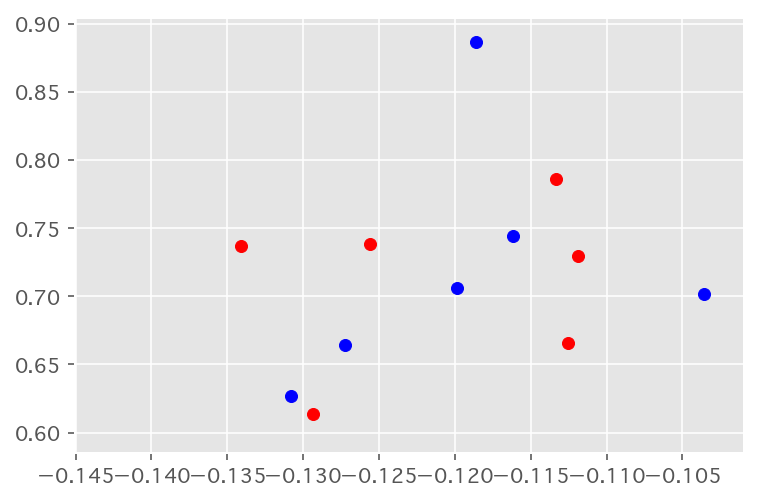

In [18]:
plt.scatter(diffs[:6], stds[:6], color="red")
plt.scatter(diffs[6:], stds[6:], color="blue")

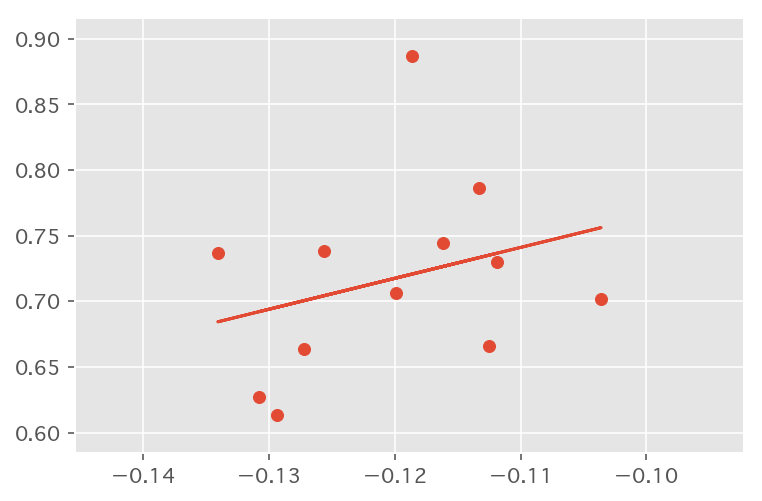

In [19]:
import statsmodels.api as sm

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.show()

In [20]:
results.pvalues

array([ 0.00647161,  0.35366761])

# MLBでの使い方

In [ ]:
files = os.listdir("/Users/konoharuki/Desktop/GitHub/baseball/game_detail_data_mlb")[1:]

In [ ]:
res = []
for file in files:
    res.append(pd.read_csv("/Users/konoharuki/Desktop/GitHub/baseball/game_detail_data_mlb/"+file, encoding="cp932", dtype=str).values.tolist())

In [ ]:
inning_list = []
for elem in res:
    inning_list.append(np.array(elem)[:, 1].tolist() + ["GAMESET"])

In [ ]:
#make_flattened_list(make_inning_triple(inning_list))

In [2]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)

In [3]:
event_df

,状況,打順,打者,結果,アウト,裏得点,表得点,イニング,表裏,攻撃チーム
0,0000,1,ホルト,空振り三振,1,0,0,1,表,Rソックス
1,1000,2,ペドロイア,空振り三振,2,0,0,1,表,Rソックス
2,2000,3,ベニンテンディ,四球,2,0,0,1,表,Rソックス
3,2100,4,モアランド,右フライ,3,0,0,1,表,Rソックス
4,0000,1,キンズラー,中安打,0,0,0,1,裏,タイガース
5,0100,2,カステラノス,四球,0,0,0,1,裏,タイガース
6,0110,3,カブレラ,右邪飛,1,0,0,1,裏,タイガース
7,1101,4,マルティネス,左犠飛,2,1,0,1,裏,タイガース
8,2100,5,アップトン,四球,2,1,0,1,裏,タイガース
9,2110,6,コリンズ,空振り三振,3,1,0,1,裏,タイガース
